In [ ]:
!pip install torch torchvision matplotlib pillow

In [2]:
import torch
import torchvision
import torch.nn as nn
import itertools
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import os
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
from MyTensorDataset import MyTensorDataset


## Hyperparameters

In [31]:
num_epochs = 200
batch_size = 64 #10 #64

In [5]:
# Define path to dataset
data_path = r'.\2_layers'

In [15]:
# Create the dataset
dataset = MyTensorDataset(data_path)
classes = ('black', 'cat')

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 4, persistent_workers=True)

# Example: iterating through the DataLoader
#for batch_tensors, batch_labels in dataloader:
#    print(batch_tensors)  # The batch tensors
#    print(batch_labels)   # The corresponding labels for each tensor
asd = []
for t,l in dataset:
    if l == 0:
        asd.append(l)
print(len(asd))

a= []
b=[]
for batch_index, (real_A, real_B) in enumerate(dataloader):
    a.append(real_A)
    b.append(real_B)
print(len(a))
print(len(b))
print(a[0].shape)
print(b[0])

2749
71
71
torch.Size([64, 6, 16, 5, 5])
tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0])


## Setup device

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Define Model

In [27]:
# Generator (U-Net inspired)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(6, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 6, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.main(x)

# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(6, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv3d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)


## Loss Function

In [28]:
#Adversarial Loss: Encourages generators to produce realistic images.
#Cycle-Consistency Loss: Ensures the transformation is reversible.
#Identity Loss (Optional): Preserves key features of the input.
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

## Training Loop

In [33]:
# Initialize models
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Optimizers
optimizer_G = Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch [{epoch +1 }/{num_epochs}]")
    real_A = []
    real_B = []
    for batch_index, (data,labels) in enumerate(tqdm(dataloader)):
        #print(len(batch_data))
        #print(len(batch_data[0]),batch_data[1])
        real_A = data[labels == 0]  # Data for domain A
        real_B = data[labels == 1]
        
        #print(len(real_A),len(real_B))
        real_A, real_B = real_A.to(device), real_B.to(device)
        #print(real_A.shape)
        #print(real_B.shape)
        # Train Generators
        optimizer_G.zero_grad()

        # GAN loss
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)
        loss_G_A2B = adversarial_loss(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_G_B2A = adversarial_loss(D_A(fake_A), torch.ones_like(D_A(fake_A)))

        # Cycle-consistency loss
        reconstructed_A = G_B2A(fake_B)
        reconstructed_B = G_A2B(fake_A)
        loss_cycle_A = cycle_loss(reconstructed_A, real_A)
        loss_cycle_B = cycle_loss(reconstructed_B, real_B)

        # Total generator loss
        loss_G = loss_G_A2B + loss_G_B2A + 10 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators
        optimizer_D_A.zero_grad()
        loss_D_A = (adversarial_loss(D_A(real_A), torch.ones_like(D_A(real_A))) +
                    adversarial_loss(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A.detach())))) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        loss_D_B = (adversarial_loss(D_B(real_B), torch.ones_like(D_B(real_B))) +
                    adversarial_loss(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B.detach())))) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch {epoch}/{num_epochs}, Loss G: {loss_G.item()},Loss D_A: {loss_D_A.item()}, Loss D_B: {loss_D_B.item()}")


Epoch [1/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.50it/s]


Epoch 0/200, Loss G: 1.5202357769012451,Loss D_A: 0.24351927638053894, Loss D_B: 0.24140304327011108
Epoch [2/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.71it/s]


Epoch 1/200, Loss G: 1.5406556129455566,Loss D_A: 0.22613032162189484, Loss D_B: 0.21443191170692444
Epoch [3/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.37it/s]


Epoch 2/200, Loss G: 1.4206814765930176,Loss D_A: 0.2677449584007263, Loss D_B: 0.2596045434474945
Epoch [4/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.20it/s]


Epoch 3/200, Loss G: 1.3708244562149048,Loss D_A: 0.24628669023513794, Loss D_B: 0.24754899740219116
Epoch [5/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.33it/s]


Epoch 4/200, Loss G: 1.320541262626648,Loss D_A: 0.2472229152917862, Loss D_B: 0.24631062150001526
Epoch [6/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.36it/s]


Epoch 5/200, Loss G: 1.266043782234192,Loss D_A: 0.24639227986335754, Loss D_B: 0.24536849558353424
Epoch [7/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.87it/s]


Epoch 6/200, Loss G: 1.240910291671753,Loss D_A: 0.2469712644815445, Loss D_B: 0.24324452877044678
Epoch [8/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.40it/s]


Epoch 7/200, Loss G: 1.2427804470062256,Loss D_A: 0.24291503429412842, Loss D_B: 0.24089354276657104
Epoch [9/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.20it/s]


Epoch 8/200, Loss G: 1.1589906215667725,Loss D_A: 0.24582041800022125, Loss D_B: 0.24748706817626953
Epoch [10/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.01it/s]


Epoch 9/200, Loss G: 1.2093658447265625,Loss D_A: 0.2506093978881836, Loss D_B: 0.24236010015010834
Epoch [11/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.61it/s]


Epoch 10/200, Loss G: 1.142234444618225,Loss D_A: 0.24517881870269775, Loss D_B: 0.24731722474098206
Epoch [12/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.72it/s]


Epoch 11/200, Loss G: 1.106432318687439,Loss D_A: 0.2528001368045807, Loss D_B: 0.2533664107322693
Epoch [13/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.55it/s]


Epoch 12/200, Loss G: 1.147754192352295,Loss D_A: 0.2454850971698761, Loss D_B: 0.24237579107284546
Epoch [14/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.56it/s]


Epoch 13/200, Loss G: 1.099158525466919,Loss D_A: 0.24448610842227936, Loss D_B: 0.23665860295295715
Epoch [15/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.57it/s]


Epoch 14/200, Loss G: 1.0634188652038574,Loss D_A: 0.24716949462890625, Loss D_B: 0.24493344128131866
Epoch [16/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.08it/s]


Epoch 15/200, Loss G: 1.0320438146591187,Loss D_A: 0.24848335981369019, Loss D_B: 0.24700488150119781
Epoch [17/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.27it/s]


Epoch 16/200, Loss G: 1.031148910522461,Loss D_A: 0.2468148171901703, Loss D_B: 0.24496757984161377
Epoch [18/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.09it/s]


Epoch 17/200, Loss G: 1.0098958015441895,Loss D_A: 0.25100621581077576, Loss D_B: 0.24049292504787445
Epoch [19/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.56it/s]


Epoch 18/200, Loss G: 1.0290546417236328,Loss D_A: 0.250307559967041, Loss D_B: 0.24429093301296234
Epoch [20/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.28it/s]


Epoch 19/200, Loss G: 1.0237793922424316,Loss D_A: 0.24663275480270386, Loss D_B: 0.2383359670639038
Epoch [21/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.40it/s]


Epoch 20/200, Loss G: 0.9913877248764038,Loss D_A: 0.24569135904312134, Loss D_B: 0.24258887767791748
Epoch [22/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.76it/s]


Epoch 21/200, Loss G: 0.9611456990242004,Loss D_A: 0.2492203414440155, Loss D_B: 0.240046426653862
Epoch [23/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.04it/s]


Epoch 22/200, Loss G: 1.0052127838134766,Loss D_A: 0.2517251670360565, Loss D_B: 0.24567189812660217
Epoch [24/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.45it/s]


Epoch 23/200, Loss G: 0.9848915934562683,Loss D_A: 0.2442951500415802, Loss D_B: 0.23807954788208008
Epoch [25/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.52it/s]


Epoch 24/200, Loss G: 0.9269217848777771,Loss D_A: 0.2494381070137024, Loss D_B: 0.24466682970523834
Epoch [26/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.39it/s]


Epoch 25/200, Loss G: 0.9218072891235352,Loss D_A: 0.2494385987520218, Loss D_B: 0.25130417943000793
Epoch [27/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.60it/s]


Epoch 26/200, Loss G: 0.9072840213775635,Loss D_A: 0.24793407320976257, Loss D_B: 0.24397757649421692
Epoch [28/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.38it/s]


Epoch 27/200, Loss G: 0.8935389518737793,Loss D_A: 0.2502986788749695, Loss D_B: 0.24878111481666565
Epoch [29/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.62it/s]


Epoch 28/200, Loss G: 0.918848991394043,Loss D_A: 0.2497170865535736, Loss D_B: 0.24216228723526
Epoch [30/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.06it/s]


Epoch 29/200, Loss G: 0.892733633518219,Loss D_A: 0.2475481778383255, Loss D_B: 0.2490459382534027
Epoch [31/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.60it/s]


Epoch 30/200, Loss G: 0.8590056896209717,Loss D_A: 0.24758031964302063, Loss D_B: 0.2441275417804718
Epoch [32/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.57it/s]


Epoch 31/200, Loss G: 0.9171810150146484,Loss D_A: 0.250131219625473, Loss D_B: 0.24767529964447021
Epoch [33/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.16it/s]


Epoch 32/200, Loss G: 0.9041197896003723,Loss D_A: 0.24734115600585938, Loss D_B: 0.2465202808380127
Epoch [34/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 19.64it/s]


Epoch 33/200, Loss G: 0.8853402137756348,Loss D_A: 0.24538958072662354, Loss D_B: 0.2484094798564911
Epoch [35/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.49it/s]


Epoch 34/200, Loss G: 0.8679088354110718,Loss D_A: 0.2478349208831787, Loss D_B: 0.2489662766456604
Epoch [36/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.14it/s]


Epoch 35/200, Loss G: 0.8662664294242859,Loss D_A: 0.25076210498809814, Loss D_B: 0.24826613068580627
Epoch [37/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.39it/s]


Epoch 36/200, Loss G: 0.8690390586853027,Loss D_A: 0.24718402326107025, Loss D_B: 0.24686065316200256
Epoch [38/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.41it/s]


Epoch 37/200, Loss G: 0.858095109462738,Loss D_A: 0.2482081800699234, Loss D_B: 0.24771356582641602
Epoch [39/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.30it/s]


Epoch 38/200, Loss G: 0.8560844659805298,Loss D_A: 0.2520905137062073, Loss D_B: 0.25490498542785645
Epoch [40/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.67it/s]


Epoch 39/200, Loss G: 0.8502070903778076,Loss D_A: 0.24913877248764038, Loss D_B: 0.24633124470710754
Epoch [41/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.31it/s]


Epoch 40/200, Loss G: 0.8117527365684509,Loss D_A: 0.25027206540107727, Loss D_B: 0.2472192943096161
Epoch [42/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.58it/s]


Epoch 41/200, Loss G: 0.8507922887802124,Loss D_A: 0.2481420338153839, Loss D_B: 0.2455778419971466
Epoch [43/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.25it/s]


Epoch 42/200, Loss G: 0.804252028465271,Loss D_A: 0.24931785464286804, Loss D_B: 0.2498892992734909
Epoch [44/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.27it/s]


Epoch 43/200, Loss G: 0.8663805723190308,Loss D_A: 0.24801765382289886, Loss D_B: 0.24437947571277618
Epoch [45/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.43it/s]


Epoch 44/200, Loss G: 0.7895170450210571,Loss D_A: 0.24940453469753265, Loss D_B: 0.24985459446907043
Epoch [46/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.59it/s]


Epoch 45/200, Loss G: 0.8406717777252197,Loss D_A: 0.2446361631155014, Loss D_B: 0.24753183126449585
Epoch [47/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.33it/s]


Epoch 46/200, Loss G: 0.801730215549469,Loss D_A: 0.2493610382080078, Loss D_B: 0.2452286183834076
Epoch [48/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.44it/s]


Epoch 47/200, Loss G: 0.8399397134780884,Loss D_A: 0.2500513792037964, Loss D_B: 0.23927028477191925
Epoch [49/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.09it/s]


Epoch 48/200, Loss G: 0.8072770833969116,Loss D_A: 0.24232369661331177, Loss D_B: 0.24157506227493286
Epoch [50/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.91it/s]


Epoch 49/200, Loss G: 0.8175829648971558,Loss D_A: 0.24405279755592346, Loss D_B: 0.24481025338172913
Epoch [51/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.60it/s]


Epoch 50/200, Loss G: 0.7993661165237427,Loss D_A: 0.24218636751174927, Loss D_B: 0.24471941590309143
Epoch [52/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.39it/s]


Epoch 51/200, Loss G: 0.8387815952301025,Loss D_A: 0.23632276058197021, Loss D_B: 0.2383168637752533
Epoch [53/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.17it/s]


Epoch 52/200, Loss G: 0.8190397024154663,Loss D_A: 0.24458007514476776, Loss D_B: 0.24072588980197906
Epoch [54/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.55it/s]


Epoch 53/200, Loss G: 0.7836444973945618,Loss D_A: 0.24401789903640747, Loss D_B: 0.2432597279548645
Epoch [55/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.60it/s]


Epoch 54/200, Loss G: 0.8521778583526611,Loss D_A: 0.24451470375061035, Loss D_B: 0.23685570061206818
Epoch [56/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.36it/s]


Epoch 55/200, Loss G: 0.8139995336532593,Loss D_A: 0.24389880895614624, Loss D_B: 0.23966707289218903
Epoch [57/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.67it/s]


Epoch 56/200, Loss G: 0.7742345929145813,Loss D_A: 0.2455008625984192, Loss D_B: 0.23983031511306763
Epoch [58/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.74it/s]


Epoch 57/200, Loss G: 0.779086709022522,Loss D_A: 0.24791285395622253, Loss D_B: 0.24204516410827637
Epoch [59/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.67it/s]


Epoch 58/200, Loss G: 0.7960965633392334,Loss D_A: 0.24083057045936584, Loss D_B: 0.23783442378044128
Epoch [60/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.38it/s]


Epoch 59/200, Loss G: 0.7839885950088501,Loss D_A: 0.24321433901786804, Loss D_B: 0.24267727136611938
Epoch [61/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.27it/s]


Epoch 60/200, Loss G: 0.760301411151886,Loss D_A: 0.24229611456394196, Loss D_B: 0.23519018292427063
Epoch [62/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.57it/s]


Epoch 61/200, Loss G: 0.766576886177063,Loss D_A: 0.2462294101715088, Loss D_B: 0.2349221408367157
Epoch [63/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.96it/s]


Epoch 62/200, Loss G: 0.7659821510314941,Loss D_A: 0.24142180383205414, Loss D_B: 0.23859116435050964
Epoch [64/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.27it/s]


Epoch 63/200, Loss G: 0.7682220935821533,Loss D_A: 0.24809415638446808, Loss D_B: 0.2392636239528656
Epoch [65/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.53it/s]


Epoch 64/200, Loss G: 0.7694869041442871,Loss D_A: 0.24155713617801666, Loss D_B: 0.24271109700202942
Epoch [66/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.18it/s]


Epoch 65/200, Loss G: 0.799052357673645,Loss D_A: 0.24245339632034302, Loss D_B: 0.2320142388343811
Epoch [67/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.05it/s]


Epoch 66/200, Loss G: 0.790056586265564,Loss D_A: 0.25452303886413574, Loss D_B: 0.23743286728858948
Epoch [68/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.62it/s]


Epoch 67/200, Loss G: 0.8332377672195435,Loss D_A: 0.24743430316448212, Loss D_B: 0.23309659957885742
Epoch [69/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.64it/s]


Epoch 68/200, Loss G: 0.7685105800628662,Loss D_A: 0.24366632103919983, Loss D_B: 0.24511179327964783
Epoch [70/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.26it/s]


Epoch 69/200, Loss G: 0.7698503136634827,Loss D_A: 0.25167059898376465, Loss D_B: 0.23813648521900177
Epoch [71/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.27it/s]


Epoch 70/200, Loss G: 0.7355557084083557,Loss D_A: 0.24657830595970154, Loss D_B: 0.23592853546142578
Epoch [72/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.47it/s]


Epoch 71/200, Loss G: 0.7842668890953064,Loss D_A: 0.2528229355812073, Loss D_B: 0.24093008041381836
Epoch [73/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.10it/s]


Epoch 72/200, Loss G: 0.8048816919326782,Loss D_A: 0.257941871881485, Loss D_B: 0.2362615317106247
Epoch [74/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.00it/s]


Epoch 73/200, Loss G: 0.7307224273681641,Loss D_A: 0.25139719247817993, Loss D_B: 0.241743266582489
Epoch [75/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.75it/s]


Epoch 74/200, Loss G: 0.7871904373168945,Loss D_A: 0.2502012848854065, Loss D_B: 0.23982246220111847
Epoch [76/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.61it/s]


Epoch 75/200, Loss G: 0.7630293965339661,Loss D_A: 0.2391771823167801, Loss D_B: 0.2399405539035797
Epoch [77/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.29it/s]


Epoch 76/200, Loss G: 0.7690397500991821,Loss D_A: 0.24282468855381012, Loss D_B: 0.23666051030158997
Epoch [78/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.29it/s]


Epoch 77/200, Loss G: 0.8052883148193359,Loss D_A: 0.2415732890367508, Loss D_B: 0.2379048764705658
Epoch [79/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.11it/s]


Epoch 78/200, Loss G: 0.7942982316017151,Loss D_A: 0.2394619733095169, Loss D_B: 0.23952162265777588
Epoch [80/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.35it/s]


Epoch 79/200, Loss G: 0.7730802297592163,Loss D_A: 0.2495597004890442, Loss D_B: 0.23787561058998108
Epoch [81/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.43it/s]


Epoch 80/200, Loss G: 0.7691076397895813,Loss D_A: 0.24018791317939758, Loss D_B: 0.2451484203338623
Epoch [82/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.46it/s]


Epoch 81/200, Loss G: 0.7814710736274719,Loss D_A: 0.2438407838344574, Loss D_B: 0.23685060441493988
Epoch [83/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.28it/s]


Epoch 82/200, Loss G: 0.7649050951004028,Loss D_A: 0.24918004870414734, Loss D_B: 0.23330019414424896
Epoch [84/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.40it/s]


Epoch 83/200, Loss G: 0.7798178791999817,Loss D_A: 0.24654801189899445, Loss D_B: 0.2449268102645874
Epoch [85/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.12it/s]


Epoch 84/200, Loss G: 0.73103928565979,Loss D_A: 0.2603643536567688, Loss D_B: 0.24881896376609802
Epoch [86/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.17it/s]


Epoch 85/200, Loss G: 0.7969678640365601,Loss D_A: 0.24462826550006866, Loss D_B: 0.24501587450504303
Epoch [87/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.46it/s]


Epoch 86/200, Loss G: 0.766132652759552,Loss D_A: 0.24423804879188538, Loss D_B: 0.2402769774198532
Epoch [88/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.21it/s]


Epoch 87/200, Loss G: 0.7851371169090271,Loss D_A: 0.2495814859867096, Loss D_B: 0.24002987146377563
Epoch [89/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.21it/s]


Epoch 88/200, Loss G: 0.7678799033164978,Loss D_A: 0.237619087100029, Loss D_B: 0.24173355102539062
Epoch [90/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.47it/s]


Epoch 89/200, Loss G: 0.7397627830505371,Loss D_A: 0.24661175906658173, Loss D_B: 0.24257054924964905
Epoch [91/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.09it/s]


Epoch 90/200, Loss G: 0.7828118801116943,Loss D_A: 0.2438965141773224, Loss D_B: 0.23744536936283112
Epoch [92/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.53it/s]


Epoch 91/200, Loss G: 0.7496631145477295,Loss D_A: 0.2501763105392456, Loss D_B: 0.2469848096370697
Epoch [93/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.17it/s]


Epoch 92/200, Loss G: 0.8057355284690857,Loss D_A: 0.2537856101989746, Loss D_B: 0.23400472104549408
Epoch [94/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.90it/s]


Epoch 93/200, Loss G: 0.7835633754730225,Loss D_A: 0.23987707495689392, Loss D_B: 0.2347090244293213
Epoch [95/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.51it/s]


Epoch 94/200, Loss G: 0.7807750105857849,Loss D_A: 0.23611989617347717, Loss D_B: 0.24093122780323029
Epoch [96/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.57it/s]


Epoch 95/200, Loss G: 0.7780892848968506,Loss D_A: 0.23984022438526154, Loss D_B: 0.24316948652267456
Epoch [97/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.54it/s]


Epoch 96/200, Loss G: 0.7315453886985779,Loss D_A: 0.24525491893291473, Loss D_B: 0.24107113480567932
Epoch [98/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.54it/s]


Epoch 97/200, Loss G: 0.7480665445327759,Loss D_A: 0.24708744883537292, Loss D_B: 0.25330281257629395
Epoch [99/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.16it/s]


Epoch 98/200, Loss G: 0.7225828766822815,Loss D_A: 0.24039697647094727, Loss D_B: 0.24792145192623138
Epoch [100/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.42it/s]


Epoch 99/200, Loss G: 0.7999637126922607,Loss D_A: 0.22694045305252075, Loss D_B: 0.23179158568382263
Epoch [101/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.71it/s]


Epoch 100/200, Loss G: 0.7694623470306396,Loss D_A: 0.23490631580352783, Loss D_B: 0.24762457609176636
Epoch [102/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.28it/s]


Epoch 101/200, Loss G: 0.766287088394165,Loss D_A: 0.24370700120925903, Loss D_B: 0.24071744084358215
Epoch [103/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.30it/s]


Epoch 102/200, Loss G: 0.7729583382606506,Loss D_A: 0.2419677972793579, Loss D_B: 0.24449294805526733
Epoch [104/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.23it/s]


Epoch 103/200, Loss G: 0.7520066499710083,Loss D_A: 0.24851378798484802, Loss D_B: 0.24163076281547546
Epoch [105/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.65it/s]


Epoch 104/200, Loss G: 0.7561350464820862,Loss D_A: 0.24384446442127228, Loss D_B: 0.24000315368175507
Epoch [106/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.18it/s]


Epoch 105/200, Loss G: 0.7982313632965088,Loss D_A: 0.24061909317970276, Loss D_B: 0.24880680441856384
Epoch [107/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.42it/s]


Epoch 106/200, Loss G: 0.7489664554595947,Loss D_A: 0.2492181360721588, Loss D_B: 0.23746725916862488
Epoch [108/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.40it/s]


Epoch 107/200, Loss G: 0.7382029891014099,Loss D_A: 0.2430649995803833, Loss D_B: 0.24576729536056519
Epoch [109/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.67it/s]


Epoch 108/200, Loss G: 0.7926719188690186,Loss D_A: 0.2367999106645584, Loss D_B: 0.23903053998947144
Epoch [110/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.24it/s]


Epoch 109/200, Loss G: 0.7389082908630371,Loss D_A: 0.2522749602794647, Loss D_B: 0.24355904757976532
Epoch [111/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.39it/s]


Epoch 110/200, Loss G: 0.7588649988174438,Loss D_A: 0.23996226489543915, Loss D_B: 0.2440480887889862
Epoch [112/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.63it/s]


Epoch 111/200, Loss G: 0.7879371643066406,Loss D_A: 0.23218318819999695, Loss D_B: 0.23692631721496582
Epoch [113/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.22it/s]


Epoch 112/200, Loss G: 0.7585285902023315,Loss D_A: 0.24549542367458344, Loss D_B: 0.24219785630702972
Epoch [114/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.46it/s]


Epoch 113/200, Loss G: 0.7608319520950317,Loss D_A: 0.26084181666374207, Loss D_B: 0.24306625127792358
Epoch [115/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.35it/s]


Epoch 114/200, Loss G: 0.7493139505386353,Loss D_A: 0.23854395747184753, Loss D_B: 0.23562955856323242
Epoch [116/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.42it/s]


Epoch 115/200, Loss G: 0.7893678545951843,Loss D_A: 0.24714204668998718, Loss D_B: 0.24308748543262482
Epoch [117/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.15it/s]


Epoch 116/200, Loss G: 0.7638788819313049,Loss D_A: 0.24048778414726257, Loss D_B: 0.24561837315559387
Epoch [118/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.11it/s]


Epoch 117/200, Loss G: 0.7546288967132568,Loss D_A: 0.24359413981437683, Loss D_B: 0.23614230751991272
Epoch [119/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.20it/s]


Epoch 118/200, Loss G: 0.7434259653091431,Loss D_A: 0.24280066788196564, Loss D_B: 0.2402162253856659
Epoch [120/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.12it/s]


Epoch 119/200, Loss G: 0.7755693197250366,Loss D_A: 0.23342527449131012, Loss D_B: 0.22639164328575134
Epoch [121/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.28it/s]


Epoch 120/200, Loss G: 0.7497230768203735,Loss D_A: 0.2431023120880127, Loss D_B: 0.24150411784648895
Epoch [122/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.78it/s]


Epoch 121/200, Loss G: 0.7339898347854614,Loss D_A: 0.24576041102409363, Loss D_B: 0.248432919383049
Epoch [123/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.23it/s]


Epoch 122/200, Loss G: 0.7400332689285278,Loss D_A: 0.2365131974220276, Loss D_B: 0.2403995394706726
Epoch [124/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.29it/s]


Epoch 123/200, Loss G: 0.7391651272773743,Loss D_A: 0.2386261522769928, Loss D_B: 0.24196907877922058
Epoch [125/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.83it/s]


Epoch 124/200, Loss G: 0.7281864881515503,Loss D_A: 0.2466588020324707, Loss D_B: 0.23663151264190674
Epoch [126/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.79it/s]


Epoch 125/200, Loss G: 0.7949463129043579,Loss D_A: 0.2461441308259964, Loss D_B: 0.2462817281484604
Epoch [127/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.27it/s]


Epoch 126/200, Loss G: 0.7592548131942749,Loss D_A: 0.2446431815624237, Loss D_B: 0.2467474639415741
Epoch [128/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.08it/s]


Epoch 127/200, Loss G: 0.7564993500709534,Loss D_A: 0.24088655412197113, Loss D_B: 0.2457798272371292
Epoch [129/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.14it/s]


Epoch 128/200, Loss G: 0.7283867597579956,Loss D_A: 0.23873400688171387, Loss D_B: 0.24322868883609772
Epoch [130/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.43it/s]


Epoch 129/200, Loss G: 0.7647280693054199,Loss D_A: 0.2415243685245514, Loss D_B: 0.2338431179523468
Epoch [131/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.41it/s]


Epoch 130/200, Loss G: 0.7574341297149658,Loss D_A: 0.2419011890888214, Loss D_B: 0.23904579877853394
Epoch [132/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.25it/s]


Epoch 131/200, Loss G: 0.7670296430587769,Loss D_A: 0.240328848361969, Loss D_B: 0.2438308298587799
Epoch [133/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.28it/s]


Epoch 132/200, Loss G: 0.7226157188415527,Loss D_A: 0.24197733402252197, Loss D_B: 0.24411439895629883
Epoch [134/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.91it/s]


Epoch 133/200, Loss G: 0.7299912571907043,Loss D_A: 0.2426167130470276, Loss D_B: 0.24535828828811646
Epoch [135/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.33it/s]


Epoch 134/200, Loss G: 0.7717055082321167,Loss D_A: 0.2412922978401184, Loss D_B: 0.2388942688703537
Epoch [136/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.54it/s]


Epoch 135/200, Loss G: 0.7086512446403503,Loss D_A: 0.24224795401096344, Loss D_B: 0.24206726253032684
Epoch [137/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.48it/s]


Epoch 136/200, Loss G: 0.7290406823158264,Loss D_A: 0.2434106171131134, Loss D_B: 0.24176177382469177
Epoch [138/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.39it/s]


Epoch 137/200, Loss G: 0.7529481649398804,Loss D_A: 0.24405592679977417, Loss D_B: 0.24535639584064484
Epoch [139/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.61it/s]


Epoch 138/200, Loss G: 0.7282940149307251,Loss D_A: 0.24434128403663635, Loss D_B: 0.23889359831809998
Epoch [140/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.59it/s]


Epoch 139/200, Loss G: 0.7308024168014526,Loss D_A: 0.24065449833869934, Loss D_B: 0.24473965167999268
Epoch [141/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.05it/s]


Epoch 140/200, Loss G: 0.7465475797653198,Loss D_A: 0.24598988890647888, Loss D_B: 0.2534447908401489
Epoch [142/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.09it/s]


Epoch 141/200, Loss G: 0.7651480436325073,Loss D_A: 0.23865871131420135, Loss D_B: 0.2349204123020172
Epoch [143/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.06it/s]


Epoch 142/200, Loss G: 0.7271476984024048,Loss D_A: 0.2454446256160736, Loss D_B: 0.2436971664428711
Epoch [144/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.89it/s]


Epoch 143/200, Loss G: 0.7617052793502808,Loss D_A: 0.23226198554039001, Loss D_B: 0.23435808718204498
Epoch [145/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.64it/s]


Epoch 144/200, Loss G: 0.7445820569992065,Loss D_A: 0.2392112910747528, Loss D_B: 0.23977813124656677
Epoch [146/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.93it/s]


Epoch 145/200, Loss G: 0.7646035552024841,Loss D_A: 0.23663493990898132, Loss D_B: 0.2404748499393463
Epoch [147/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.41it/s]


Epoch 146/200, Loss G: 0.7320169806480408,Loss D_A: 0.23988911509513855, Loss D_B: 0.23362135887145996
Epoch [148/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.64it/s]


Epoch 147/200, Loss G: 0.7541155815124512,Loss D_A: 0.2387685477733612, Loss D_B: 0.24943140149116516
Epoch [149/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.24it/s]


Epoch 148/200, Loss G: 0.7439309358596802,Loss D_A: 0.23759742081165314, Loss D_B: 0.2517552673816681
Epoch [150/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.17it/s]


Epoch 149/200, Loss G: 0.7272970676422119,Loss D_A: 0.23525384068489075, Loss D_B: 0.24499759078025818
Epoch [151/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.11it/s]


Epoch 150/200, Loss G: 0.7320438027381897,Loss D_A: 0.24552622437477112, Loss D_B: 0.2447105497121811
Epoch [152/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.77it/s]


Epoch 151/200, Loss G: 0.7704039216041565,Loss D_A: 0.25838780403137207, Loss D_B: 0.23814156651496887
Epoch [153/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.98it/s]


Epoch 152/200, Loss G: 0.7771598100662231,Loss D_A: 0.2460702359676361, Loss D_B: 0.23735752701759338
Epoch [154/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.37it/s]


Epoch 153/200, Loss G: 0.7499367594718933,Loss D_A: 0.24090659618377686, Loss D_B: 0.23462392389774323
Epoch [155/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.33it/s]


Epoch 154/200, Loss G: 0.821117103099823,Loss D_A: 0.23358452320098877, Loss D_B: 0.23318101465702057
Epoch [156/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.46it/s]


Epoch 155/200, Loss G: 0.7501136064529419,Loss D_A: 0.236577570438385, Loss D_B: 0.24462378025054932
Epoch [157/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.26it/s]


Epoch 156/200, Loss G: 0.754560649394989,Loss D_A: 0.24165692925453186, Loss D_B: 0.24028554558753967
Epoch [158/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.39it/s]


Epoch 157/200, Loss G: 0.7723405957221985,Loss D_A: 0.23520728945732117, Loss D_B: 0.2405731976032257
Epoch [159/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.44it/s]


Epoch 158/200, Loss G: 0.7666555643081665,Loss D_A: 0.2463686168193817, Loss D_B: 0.2406027615070343
Epoch [160/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.16it/s]


Epoch 159/200, Loss G: 0.7643852233886719,Loss D_A: 0.24186629056930542, Loss D_B: 0.23491956293582916
Epoch [161/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.40it/s]


Epoch 160/200, Loss G: 0.7311805486679077,Loss D_A: 0.23857331275939941, Loss D_B: 0.23643434047698975
Epoch [162/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.30it/s]


Epoch 161/200, Loss G: 0.7340413331985474,Loss D_A: 0.2552567720413208, Loss D_B: 0.24263213574886322
Epoch [163/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.17it/s]


Epoch 162/200, Loss G: 0.7573044896125793,Loss D_A: 0.2516965866088867, Loss D_B: 0.24574093520641327
Epoch [164/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.40it/s]


Epoch 163/200, Loss G: 0.7661895751953125,Loss D_A: 0.24359452724456787, Loss D_B: 0.23627468943595886
Epoch [165/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.03it/s]


Epoch 164/200, Loss G: 0.739775538444519,Loss D_A: 0.2431037425994873, Loss D_B: 0.23686453700065613
Epoch [166/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.64it/s]


Epoch 165/200, Loss G: 0.756935715675354,Loss D_A: 0.24735936522483826, Loss D_B: 0.24288032948970795
Epoch [167/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.32it/s]


Epoch 166/200, Loss G: 0.712836503982544,Loss D_A: 0.23868459463119507, Loss D_B: 0.23932041227817535
Epoch [168/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.53it/s]


Epoch 167/200, Loss G: 0.7404230833053589,Loss D_A: 0.25208646059036255, Loss D_B: 0.24087083339691162
Epoch [169/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.23it/s]


Epoch 168/200, Loss G: 0.7262179851531982,Loss D_A: 0.2412838339805603, Loss D_B: 0.23076388239860535
Epoch [170/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.60it/s]


Epoch 169/200, Loss G: 0.7512690424919128,Loss D_A: 0.22877484560012817, Loss D_B: 0.23535926640033722
Epoch [171/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 23.79it/s]


Epoch 170/200, Loss G: 0.7239781618118286,Loss D_A: 0.25098296999931335, Loss D_B: 0.238875612616539
Epoch [172/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.64it/s]


Epoch 171/200, Loss G: 0.737528383731842,Loss D_A: 0.2333858609199524, Loss D_B: 0.22972726821899414
Epoch [173/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.41it/s]


Epoch 172/200, Loss G: 0.766931414604187,Loss D_A: 0.23903599381446838, Loss D_B: 0.23982878029346466
Epoch [174/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.41it/s]


Epoch 173/200, Loss G: 0.7519766092300415,Loss D_A: 0.2445450872182846, Loss D_B: 0.23946444690227509
Epoch [175/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.23it/s]


Epoch 174/200, Loss G: 0.7172296643257141,Loss D_A: 0.2396055907011032, Loss D_B: 0.23932263255119324
Epoch [176/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.13it/s]


Epoch 175/200, Loss G: 0.7016156315803528,Loss D_A: 0.24505193531513214, Loss D_B: 0.24743835628032684
Epoch [177/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.15it/s]


Epoch 176/200, Loss G: 0.7371492385864258,Loss D_A: 0.2231629490852356, Loss D_B: 0.24030755460262299
Epoch [178/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.57it/s]


Epoch 177/200, Loss G: 0.7193093299865723,Loss D_A: 0.24365770816802979, Loss D_B: 0.24056556820869446
Epoch [179/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.36it/s]


Epoch 178/200, Loss G: 0.7441588640213013,Loss D_A: 0.2423657327890396, Loss D_B: 0.23534350097179413
Epoch [180/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.08it/s]


Epoch 179/200, Loss G: 0.7657313346862793,Loss D_A: 0.24472637474536896, Loss D_B: 0.2341330647468567
Epoch [181/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.41it/s]


Epoch 180/200, Loss G: 0.7526569366455078,Loss D_A: 0.22942152619361877, Loss D_B: 0.2372445911169052
Epoch [182/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.06it/s]


Epoch 181/200, Loss G: 0.6933051347732544,Loss D_A: 0.24682463705539703, Loss D_B: 0.24249479174613953
Epoch [183/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.48it/s]


Epoch 182/200, Loss G: 0.7419168949127197,Loss D_A: 0.2370283007621765, Loss D_B: 0.2307751178741455
Epoch [184/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.38it/s]


Epoch 183/200, Loss G: 0.7563909888267517,Loss D_A: 0.24313636124134064, Loss D_B: 0.22794082760810852
Epoch [185/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.65it/s]


Epoch 184/200, Loss G: 0.7370280027389526,Loss D_A: 0.2410968542098999, Loss D_B: 0.2416369915008545
Epoch [186/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.18it/s]


Epoch 185/200, Loss G: 0.7428998947143555,Loss D_A: 0.24261993169784546, Loss D_B: 0.23222099244594574
Epoch [187/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.92it/s]


Epoch 186/200, Loss G: 0.7982322573661804,Loss D_A: 0.22589781880378723, Loss D_B: 0.22467289865016937
Epoch [188/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.99it/s]


Epoch 187/200, Loss G: 0.7410092353820801,Loss D_A: 0.24736224114894867, Loss D_B: 0.2402934581041336
Epoch [189/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.38it/s]


Epoch 188/200, Loss G: 0.7785788774490356,Loss D_A: 0.2374941110610962, Loss D_B: 0.22658970952033997
Epoch [190/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.34it/s]


Epoch 189/200, Loss G: 0.7745065689086914,Loss D_A: 0.23464885354042053, Loss D_B: 0.23578345775604248
Epoch [191/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.26it/s]


Epoch 190/200, Loss G: 0.7243117094039917,Loss D_A: 0.23985746502876282, Loss D_B: 0.2338782101869583
Epoch [192/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.60it/s]


Epoch 191/200, Loss G: 0.7235105037689209,Loss D_A: 0.23733527958393097, Loss D_B: 0.2416703701019287
Epoch [193/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.23it/s]


Epoch 192/200, Loss G: 0.7611511945724487,Loss D_A: 0.23819255828857422, Loss D_B: 0.23330050706863403
Epoch [194/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.50it/s]


Epoch 193/200, Loss G: 0.7523403167724609,Loss D_A: 0.24866679310798645, Loss D_B: 0.23843348026275635
Epoch [195/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.33it/s]


Epoch 194/200, Loss G: 0.7370331287384033,Loss D_A: 0.24177521467208862, Loss D_B: 0.24239090085029602
Epoch [196/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.49it/s]


Epoch 195/200, Loss G: 0.7260583639144897,Loss D_A: 0.24930202960968018, Loss D_B: 0.24672415852546692
Epoch [197/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.48it/s]


Epoch 196/200, Loss G: 0.7655371427536011,Loss D_A: 0.2376740276813507, Loss D_B: 0.24357280135154724
Epoch [198/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.65it/s]


Epoch 197/200, Loss G: 0.7361363768577576,Loss D_A: 0.22625678777694702, Loss D_B: 0.2385847270488739
Epoch [199/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.85it/s]


Epoch 198/200, Loss G: 0.7231085300445557,Loss D_A: 0.24696145951747894, Loss D_B: 0.24635030329227448
Epoch [200/200]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 23.25it/s]

Epoch 199/200, Loss G: 0.7434911727905273,Loss D_A: 0.22818443179130554, Loss D_B: 0.2409338802099228


## Save Models and Visualise results

In [34]:
torch.save(G_A2B.state_dict(), '2_generator_A2B.pth')
torch.save(G_B2A.state_dict(), '2_generator_B2A.pth')


In [41]:
layer = 2
model = 3
real_A = torch.load(f'./black_layers_permuted/{layer}/{layer}_{model:04}.pth', weights_only=True).to(device)
real_B = torch.load(f'./cat_layers_permuted/{layer}/{layer}_{model:04}.pth', weights_only=True).to(device)


# Assuming G_A and G_B are your trained generators
G_A2B.to(device).eval()
G_B2A.to(device).eval()

# Generate fake images (domain A -> B and B -> A)
fake_B = G_A2B(real_A).permute(1, 0, 2, 3)
fake_A = G_B2A(real_B).permute(1, 0, 2, 3)


A
B


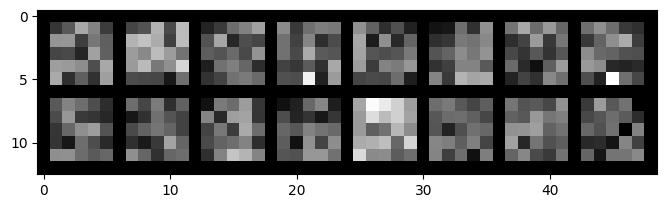

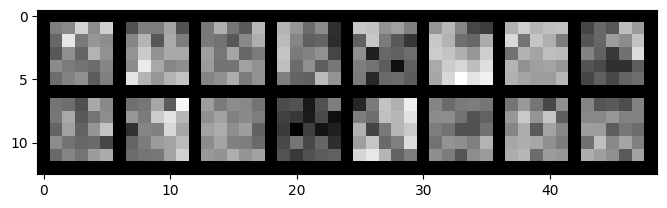

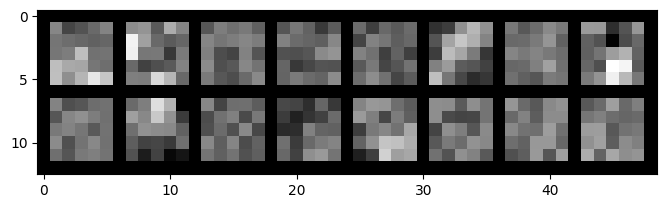

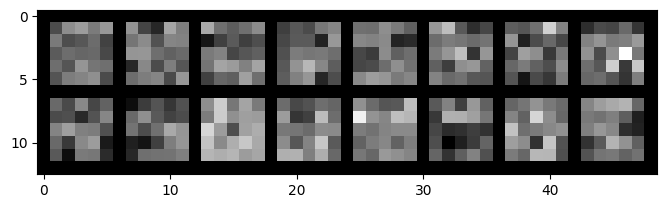

In [42]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

print("A")
visTensor(real_A.cpu().permute(1, 0, 2, 3), ch=0, allkernels=False)
visTensor(fake_A.cpu(), ch=0, allkernels=False)

print("B")
visTensor(real_B.cpu().permute(1, 0, 2, 3), ch=0, allkernels=False)
visTensor(fake_B.cpu(), ch=0, allkernels=False)